# Train CNN with FER2013 dataset


## Initializing and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the specific tensorflow version.
!pip install tensorflow==2.9.0

In [ ]:
# Check that GPU is connected.
%cd /content/drive/MyDrive/TFG_FER
import tensorflow as tf
tf.test.gpu_device_name()

/content/drive/MyDrive/TFG_FER


'/device:GPU:0'

In [ ]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, SeparableConv2D
from keras.layers import ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Input, add, Reshape, Lambda, Concatenate
from keras.layers import GlobalMaxPooling2D, MaxPool2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras import backend as K
from keras.regularizers import l2
from keras.applications.imagenet_utils import obtain_input_shape
from keras.utils import get_source_inputs
from keras import layers

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
# Check Python and packages' version.
!python3 --version
print("tensorflow: "+tf.__version__)

Python 3.9.16
tensorflow: 2.9.0


## Import dataset and preprocess

In [ ]:
# Load dataset.
data = pd.read_csv("/content/drive/MyDrive/TFG_FER/Datasets_and_packages/fer2013.csv")
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
# Group data by "Usage".
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
validation = groups[1]
test = groups[0]

In [ ]:
# Remove "Usage" column and group data by labels and pixels.
train = train.drop(labels=['Usage'], axis=1)
validation = validation.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

train_Y = train["emotion"]
validation_Y = validation["emotion"]
test_Y = test["emotion"]

train_X = train["pixels"]
validation_X = validation["pixels"]
test_X = test["pixels"]

In [ ]:
# Number of classes.
num_class = len(set(train_Y))
print(num_class)

7


### Data preprocessing



In [ ]:
# Resize from 0-255 to 0-1 pixel values and reshape into (X, 48, 48, 1).
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [ ]:
train_X = preprocess(train_X)
validation_X = preprocess(validation_X)
test_X = preprocess(test_X)

print(train_X.shape, validation_X.shape, test_X.shape)

(28709, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


In [ ]:
# One hot encoding
train_Y = to_categorical(train_Y, num_class)
validation_Y = to_categorical(validation_Y, num_class)
test_Y = to_categorical(test_Y, num_class)

print(train_Y.shape, validation_Y.shape, test_Y.shape)

(28709, 7) (3589, 7) (3589, 7)


## Functions

### Plot the history of the training and validation

In [ ]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower left')
    ax1.set_ylim([0, 1])

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='lower left')
    ax2.set_ylim([0, max(history.history['loss'])])
    
    plt.show()

### Plot the confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Model A



### Build model A

In [ ]:
def build_model_A(input_shape, num_classes):

    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(input_shape)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2,2))) 
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2,2))) 
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [ ]:
model_A = build_model_A((48,48,1), num_class)
model_A.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
plot_model(model_A, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_a.png', show_shapes=True, show_layer_names=True)

### Train model A

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_a.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_A.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 100

# Fit the model.
history = model_A.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal]
                      )

Epoch 1/50
287/287 [==============================] - 11s 32ms/step - loss: 1.9873 - accuracy: 0.2663 - val_loss: 1.7954 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/50
287/287 [==============================] - 9s 30ms/step - loss: 1.5701 - accuracy: 0.3824 - val_loss: 1.6229 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 3/50
287/287 [==============================] - 10s 34ms/step - loss: 1.4161 - accuracy: 0.4491 - val_loss: 1.3392 - val_accuracy: 0.4834 - lr: 0.0010
Epoch 4/50
287/287 [==============================] - 9s 31ms/step - loss: 1.3066 - accuracy: 0.4939 - val_loss: 1.3333 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 5/50
287/287 [==============================] - 11s 37ms/step - loss: 1.2391 - accuracy: 0.5247 - val_loss: 1.2473 - val_accuracy: 0.5186 - lr: 0.0010
Epoch 6/50
287/287 [==============================] - 9s 32ms/step - loss: 1.1965 - accuracy: 0.5453 - val_loss: 1.1424 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 7/50
287/287 [==============================] - 9s 33ms

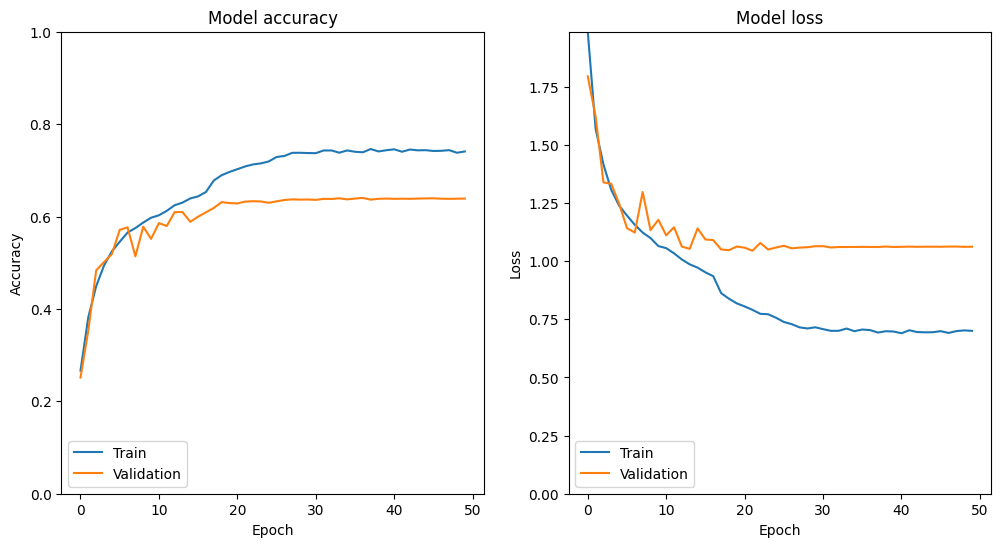

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
# Load model
model_A = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_a.h5')

In [ ]:
# Predict validation data
validation_Y_pred = model_A.predict(validation_X)

113/113 [==============================] - 1s 5ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       467
           1       0.81      0.46      0.59        56
           2       0.53      0.33      0.41       496
           3       0.85      0.83      0.84       895
           4       0.50      0.60      0.54       653
           5       0.77      0.78      0.78       415
           6       0.53      0.63      0.58       607

    accuracy                           0.64      3589
   macro avg       0.65      0.60      0.61      3589
weighted avg       0.64      0.64      0.64      3589



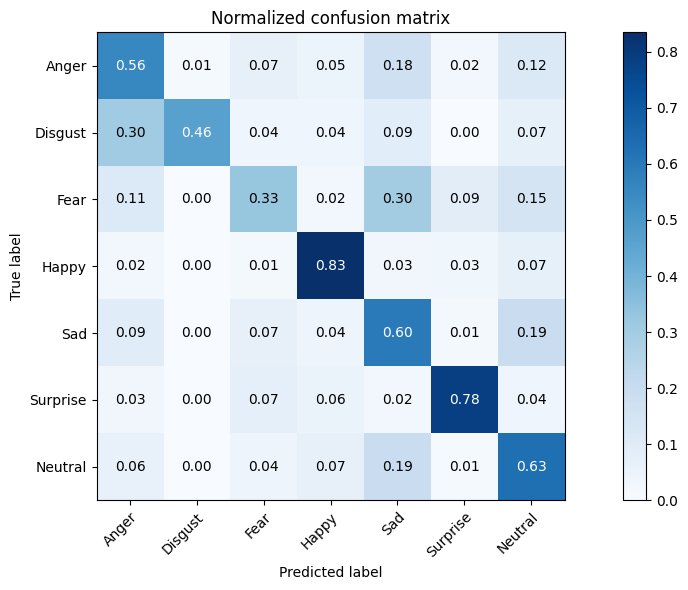

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
# Calculate loos and accuracy of test data
loss, acc = model_A.evaluate(test_X, test_Y)

113/113 [==============================] - 1s 8ms/step - loss: 1.0019 - accuracy: 0.6565


In [ ]:
test_Y_pred = model_A.predict(test_X)

113/113 [==============================] - 1s 5ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       491
           1       0.81      0.55      0.65        55
           2       0.54      0.37      0.44       528
           3       0.87      0.87      0.87       879
           4       0.47      0.60      0.53       594
           5       0.77      0.73      0.75       416
           6       0.60      0.69      0.64       626

    accuracy                           0.66      3589
   macro avg       0.67      0.62      0.64      3589
weighted avg       0.66      0.66      0.65      3589



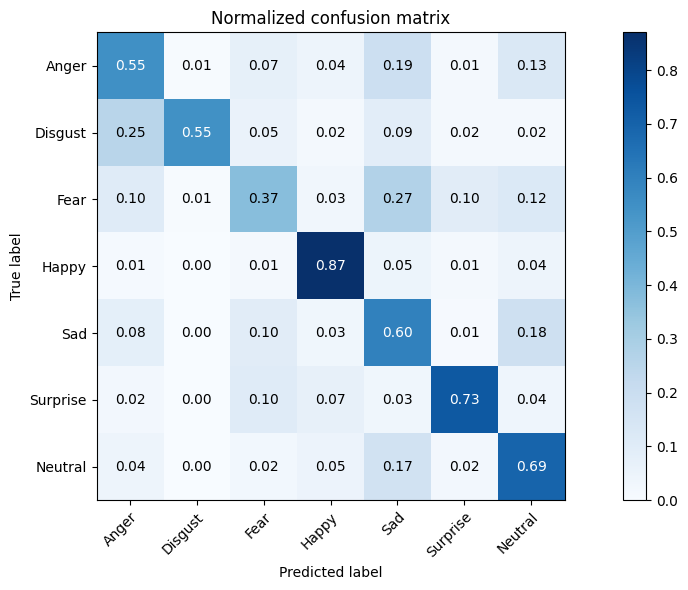

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_Y_true, test_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Model B


### Build model B



In [ ]:
def build_model_B(input_shape, num_classes):
  
  model = Sequential()

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(input_shape)))
  model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(0.5))

  #2nd convolution layer
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(0.5))

  #3rd convolution layer
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

  model.add(Flatten())

  #fully connected neural networks
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(num_classes, activation='softmax'))

  return model

In [ ]:
model_B = build_model_B((48, 48, 1), num_class)
model_B.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        3

In [ ]:
plot_model(model_B, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_b.png', show_shapes=True, show_layer_names=True)

### Train model B

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_b.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_B.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_B.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=20,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/20
448/448 [==============================] - 12s 22ms/step - loss: 1.7261 - accuracy: 0.3146 - val_loss: 1.6496 - val_accuracy: 0.3451 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 11s 24ms/step - loss: 1.5035 - accuracy: 0.4151 - val_loss: 1.4931 - val_accuracy: 0.4210 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 9s 21ms/step - loss: 1.3986 - accuracy: 0.4658 - val_loss: 1.3668 - val_accuracy: 0.4721 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 11s 24ms/step - loss: 1.3188 - accuracy: 0.4955 - val_loss: 1.9905 - val_accuracy: 0.2891 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 11s 24ms/step - loss: 1.2618 - accuracy: 0.5181 - val_loss: 1.2605 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - 9s 21ms/step - loss: 1.2046 - accuracy: 0.5417 - val_loss: 1.2772 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 7/20
448/448 [==============================] - 11s 24

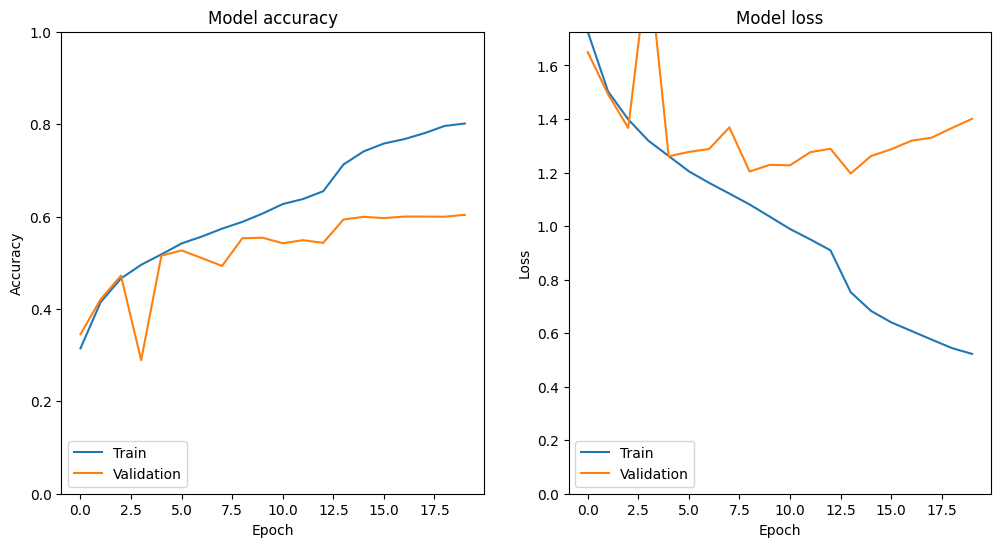

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_B = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_b.h5')

In [ ]:
validation_Y_pred = model_B.predict(validation_X)

113/113 [==============================] - 1s 5ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.52      0.50       467
           1       0.67      0.43      0.52        56
           2       0.47      0.38      0.42       496
           3       0.81      0.80      0.80       895
           4       0.49      0.52      0.51       653
           5       0.78      0.75      0.76       415
           6       0.51      0.57      0.54       607

    accuracy                           0.60      3589
   macro avg       0.60      0.57      0.58      3589
weighted avg       0.61      0.60      0.60      3589



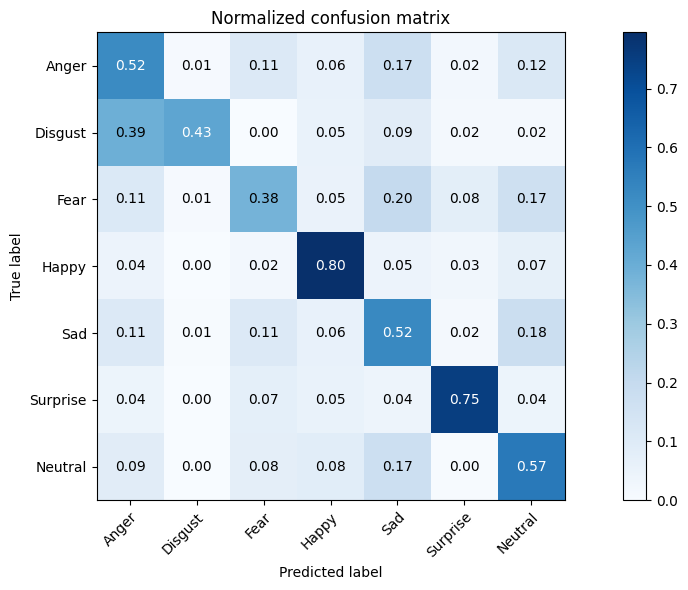

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_B.evaluate(test_X, test_Y)

113/113 [==============================] - 1s 7ms/step - loss: 1.2827 - accuracy: 0.6116


In [ ]:
test_Y_pred = model_B.predict(test_X)

113/113 [==============================] - 1s 4ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       491
           1       0.82      0.56      0.67        55
           2       0.49      0.41      0.45       528
           3       0.82      0.82      0.82       879
           4       0.42      0.49      0.45       594
           5       0.75      0.74      0.75       416
           6       0.58      0.60      0.59       626

    accuracy                           0.61      3589
   macro avg       0.63      0.59      0.61      3589
weighted avg       0.61      0.61      0.61      3589



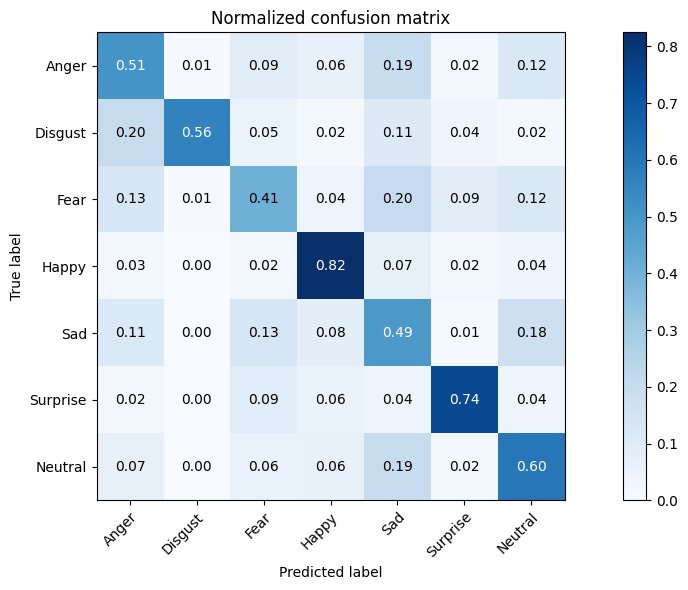

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_Y_true, test_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Model C: Mini VGG16


### Build model C

In [ ]:
def mini_VGG16(input_shape, num_class):
    drop_pram = 0.5
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal", 
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal",
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #2: second CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #3: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #4: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #5: first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #6: second set of FC => RELU layers
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #7: softmax classifier
    model.add(Dense(num_class, kernel_initializer="he_normal"))
    model.add(Activation("softmax"))

    return model

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)
model_C.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0

In [ ]:
plot_model(model_C, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_c.png', show_shapes=True, show_layer_names=True)

### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_c.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
448/448 [==============================] - 14s 24ms/step - loss: 1.9162 - accuracy: 0.2279 - val_loss: 1.8610 - val_accuracy: 0.2503 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 11s 23ms/step - loss: 1.7040 - accuracy: 0.3182 - val_loss: 1.6961 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 11s 24ms/step - loss: 1.5065 - accuracy: 0.4181 - val_loss: 1.4271 - val_accuracy: 0.4542 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 10s 23ms/step - loss: 1.4135 - accuracy: 0.4554 - val_loss: 1.4207 - val_accuracy: 0.4584 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 11s 24ms/step - loss: 1.3517 - accuracy: 0.4846 - val_loss: 1.2450 - val_accuracy: 0.5112 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 11s 23ms/step - loss: 1.3124 - accuracy: 0.4949 - val_loss: 1.3264 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 10s 

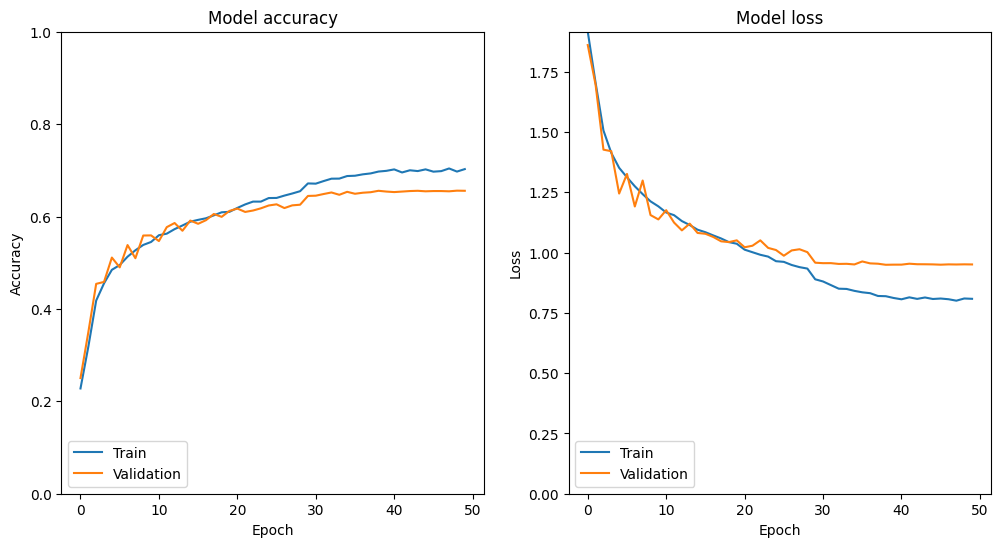

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_c.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

113/113 [==============================] - 1s 5ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       467
           1       0.62      0.52      0.56        56
           2       0.52      0.34      0.41       496
           3       0.83      0.87      0.85       895
           4       0.55      0.55      0.55       653
           5       0.79      0.82      0.80       415
           6       0.55      0.68      0.61       607

    accuracy                           0.66      3589
   macro avg       0.64      0.62      0.62      3589
weighted avg       0.65      0.66      0.65      3589



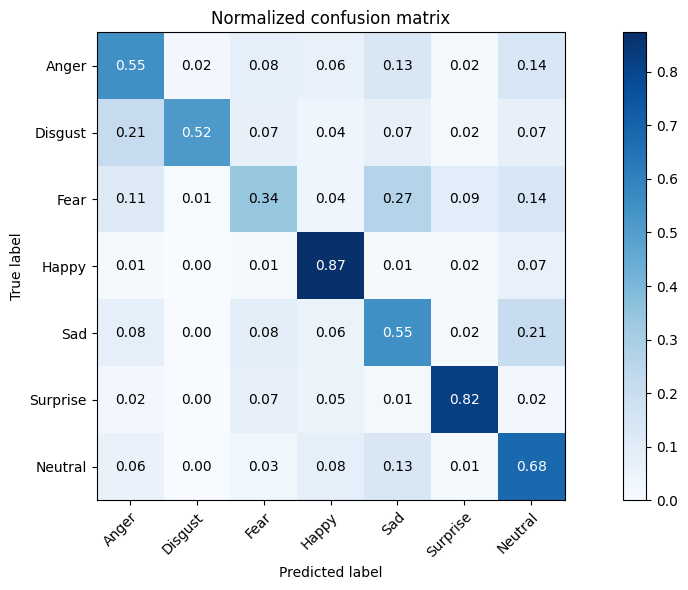

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

113/113 [==============================] - 1s 7ms/step - loss: 0.9053 - accuracy: 0.6751


In [ ]:
test_Y_pred = model_C.predict(test_X)

113/113 [==============================] - 1s 5ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       491
           1       0.62      0.69      0.66        55
           2       0.63      0.41      0.50       528
           3       0.85      0.89      0.87       879
           4       0.52      0.57      0.54       594
           5       0.75      0.79      0.77       416
           6       0.60      0.71      0.65       626

    accuracy                           0.68      3589
   macro avg       0.66      0.66      0.65      3589
weighted avg       0.67      0.68      0.67      3589



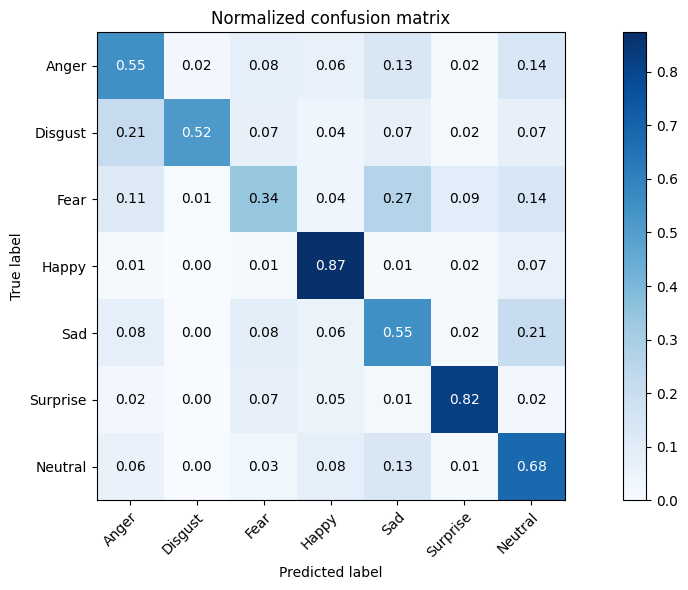

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Model D: MobileNet v2


### Build model D

In [ ]:
# MobileNet v2 utils

relu6 = ReLU(max_value=6, name="ReLU6")

def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)


def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = add([x, inputs])
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x

################################################################################

# Build MobileNet v2 architecture.

def MobileNet_v2(input_shape, num_classes):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        num_classes: Integer, number of classes.
    # Returns
        MobileNetv2 model.
    """

    inputs = Input(shape=input_shape)
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)

    x = _conv_block(x, 1280, (1, 1), strides=(1, 1))

    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(num_classes, (1, 1), padding='same')(x)

    x = Activation('softmax', name='softmax')(x)
    output = Reshape((num_classes,))(x)
    model = Model(inputs, output)
    
    return model

In [ ]:
model_D = MobileNet_v2((48, 48, 1), num_class)
model_D.summary()

NameError: ignored

In [ ]:
model_D = create_mobilenetv2((48, 48, 1), num_class)
model_D.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 16)        144       
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_14 (ReLU)             (None, 48, 48, 16)        0         
                                                                 
 depthwise_conv2d_6 (Depthwi  (None, 24, 24, 16)       144       
 seConv2D)                                                       
                                                                 
 batch_normalization_17 (Bat  (None, 24, 24, 16)       

In [ ]:
plot_model(model_D, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_d.png', show_shapes=True, show_layer_names=True)

### Train model D

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_d.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_D.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 32

# Fit the model.
history = model_D.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=25,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/25
897/897 [==============================] - 32s 30ms/step - loss: 1.8440 - accuracy: 0.2493 - val_loss: 1.7640 - val_accuracy: 0.2882 - lr: 0.0010
Epoch 2/25
897/897 [==============================] - 26s 28ms/step - loss: 1.6170 - accuracy: 0.3726 - val_loss: 1.6717 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 3/25
897/897 [==============================] - 31s 35ms/step - loss: 1.5022 - accuracy: 0.4169 - val_loss: 1.5177 - val_accuracy: 0.4099 - lr: 0.0010
Epoch 4/25
897/897 [==============================] - 31s 34ms/step - loss: 1.4349 - accuracy: 0.4469 - val_loss: 2.5703 - val_accuracy: 0.3404 - lr: 0.0010
Epoch 5/25
897/897 [==============================] - 35s 39ms/step - loss: 1.3984 - accuracy: 0.4599 - val_loss: 1.4777 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 6/25
897/897 [==============================] - 27s 30ms/step - loss: 1.3518 - accuracy: 0.4812 - val_loss: 1.3677 - val_accuracy: 0.4699 - lr: 0.0010
Epoch 7/25
897/897 [==============================] - 25s 

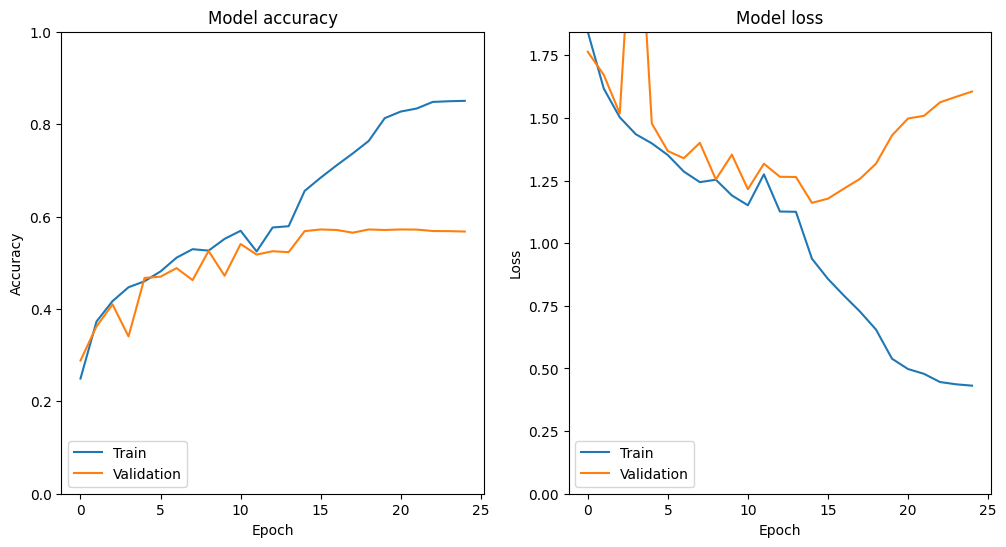

In [ ]:
plot_history(history)

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_d2.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_D.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 32

# Fit the model.
history = model_D.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=25,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/25
897/897 [==============================] - 17s 9ms/step - loss: 1.6493 - accuracy: 0.3446 - val_loss: 1.5169 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 2/25
897/897 [==============================] - 9s 9ms/step - loss: 1.4133 - accuracy: 0.4562 - val_loss: 1.4579 - val_accuracy: 0.4450 - lr: 0.0010
Epoch 3/25
897/897 [==============================] - 7s 8ms/step - loss: 1.2910 - accuracy: 0.5090 - val_loss: 1.3803 - val_accuracy: 0.4660 - lr: 0.0010
Epoch 4/25
897/897 [==============================] - 8s 9ms/step - loss: 1.2013 - accuracy: 0.5473 - val_loss: 1.5373 - val_accuracy: 0.4487 - lr: 0.0010
Epoch 5/25
897/897 [==============================] - 7s 7ms/step - loss: 1.1375 - accuracy: 0.5701 - val_loss: 1.3423 - val_accuracy: 0.4936 - lr: 0.0010
Epoch 6/25
897/897 [==============================] - 9s 10ms/step - loss: 1.0709 - accuracy: 0.5976 - val_loss: 1.5593 - val_accuracy: 0.4428 - lr: 0.0010
Epoch 7/25
897/897 [==============================] - 7s 8ms/step - 

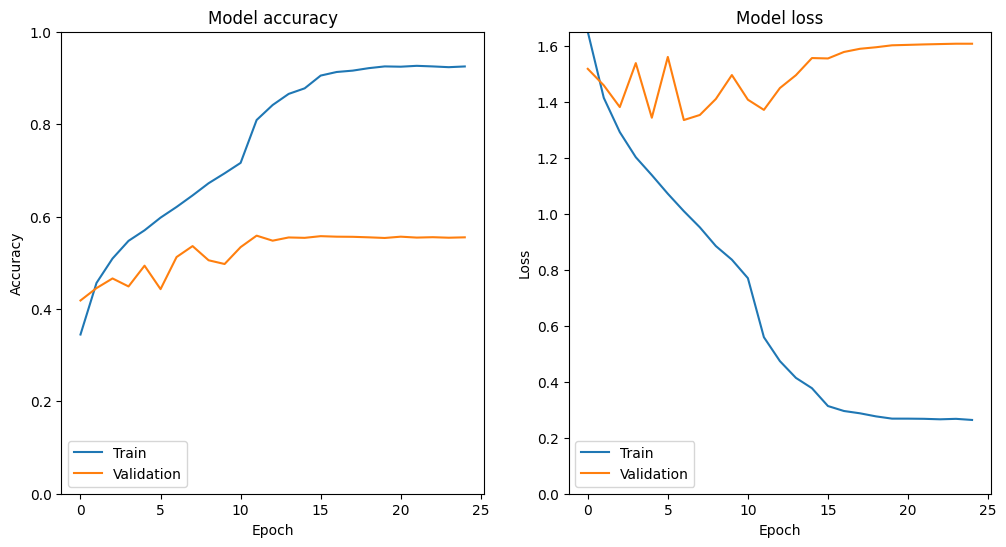

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_D = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_d.h5')

In [ ]:
validation_Y_pred = model_D.predict(validation_X)

113/113 [==============================] - 2s 8ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       467
           1       0.56      0.45      0.50        56
           2       0.39      0.37      0.38       496
           3       0.78      0.80      0.79       895
           4       0.43      0.41      0.42       653
           5       0.72      0.73      0.73       415
           6       0.51      0.52      0.52       607

    accuracy                           0.57      3589
   macro avg       0.55      0.54      0.54      3589
weighted avg       0.56      0.57      0.57      3589



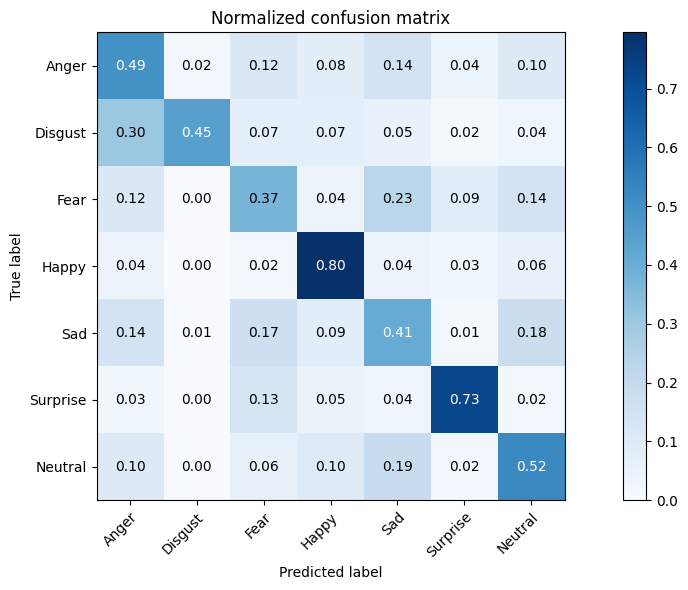

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_D.evaluate(test_X, test_Y)

113/113 [==============================] - 2s 10ms/step - loss: 1.6044 - accuracy: 0.5670


In [ ]:
test_Y_pred = model_D.predict(test_X)

113/113 [==============================] - 1s 8ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48       491
           1       0.52      0.51      0.51        55
           2       0.41      0.38      0.40       528
           3       0.78      0.79      0.79       879
           4       0.40      0.41      0.40       594
           5       0.71      0.70      0.70       416
           6       0.53      0.54      0.53       626

    accuracy                           0.57      3589
   macro avg       0.55      0.55      0.55      3589
weighted avg       0.57      0.57      0.57      3589



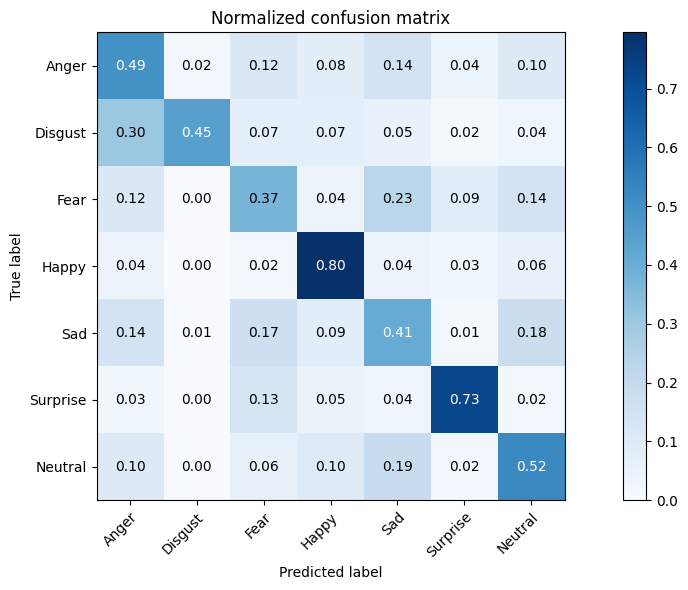

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Model E: ShuffleNet v2



### Build model E

In [ ]:
# ShuffleNet v2 utils

def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    # else:
    #     s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
    #     s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
    #     s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
    #     s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
    #     s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
    #     ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    else:
        x = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding='same',
                   name='{}/1x1conv_3'.format(prefix))(inputs)
        x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(x)
        x = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(x)
        x = DepthwiseConv2D(kernel_size=7, strides=strides, padding='same', name='{}/3x3dwconv2'.format(prefix))(x)
        x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv2'.format(prefix))(x)
        x = Conv2D(bottleneck_channels, kernel_size=1, strides=1, padding='same', name='{}/1x1conv_4'.format(prefix))(x)
        x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_4'.format(prefix))(x)
        xm = Activation('relu', name='{}/relu_1x1conv_4'.format(prefix))(x)

        x = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding='same',
                   name='{}/1x1conv_5'.format(prefix))(inputs)
        x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_5'.format(prefix))(x)
        x = Activation('relu', name='{}/relu_1x1conv_5'.format(prefix))(x)
        x = DepthwiseConv2D(kernel_size=11, strides=strides, padding='same', name='{}/3x3dwconv3'.format(prefix))(x)
        x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv3'.format(prefix))(x)
        x = Conv2D(bottleneck_channels, kernel_size=1, strides=1, padding='same', name='{}/1x1conv_6'.format(prefix))(x)
        x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_6'.format(prefix))(x)
        xl = Activation('relu', name='{}/relu_1x1conv_6'.format(prefix))(x)

        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, xm, xl])


    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        # x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
        #                   bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))
        x = shuffle_unit(x, out_channels=int(x.shape[-1])//2, strides=1,
                         bottleneck_ratio=bottleneck_ratio, stage=stage, block=(1 + i))
    return x

################################################################################

# Build ShuffleNet v2 architecture.

def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(224,224,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=1000):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = (2**exp)*0.5
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

In [ ]:
model_E = ShuffleNetV2(input_shape=(48,48,1), classes=num_class)
model_E.summary()

Model: "ShuffleNetV2_1.0_1_373"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 24)   216         ['input_1[0][0]']                
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 12, 12, 24)   0           ['conv1[0][0]']                  
                                                                                                  
 stage2/block1/1x1conv_5 (Conv2  (None, 12, 12, 58)  1450        ['maxpool1[0][0]']               
 D)                                                                          

In [ ]:
plot_model(model_E, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_e.png', show_shapes=True, show_layer_names=True)

### Train model E

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_e.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_E.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_loss', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 32

# Fit the model.
history = model_E.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=13,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/13
897/897 [==============================] - 40s 37ms/step - loss: 1.8103 - accuracy: 0.2942 - val_loss: 1.7964 - val_accuracy: 0.3058 - lr: 0.0010
Epoch 2/13
897/897 [==============================] - 31s 35ms/step - loss: 1.5390 - accuracy: 0.3997 - val_loss: 2.1941 - val_accuracy: 0.2475 - lr: 0.0010
Epoch 3/13
897/897 [==============================] - 36s 40ms/step - loss: 1.4366 - accuracy: 0.4431 - val_loss: 1.5152 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 4/13
897/897 [==============================] - 30s 34ms/step - loss: 1.3758 - accuracy: 0.4702 - val_loss: 1.3806 - val_accuracy: 0.4729 - lr: 0.0010
Epoch 5/13
897/897 [==============================] - 30s 34ms/step - loss: 1.3045 - accuracy: 0.5011 - val_loss: 1.6339 - val_accuracy: 0.4085 - lr: 0.0010
Epoch 6/13
897/897 [==============================] - 30s 34ms/step - loss: 1.2434 - accuracy: 0.5265 - val_loss: 1.6321 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 7/13
897/897 [==============================] - 30s 

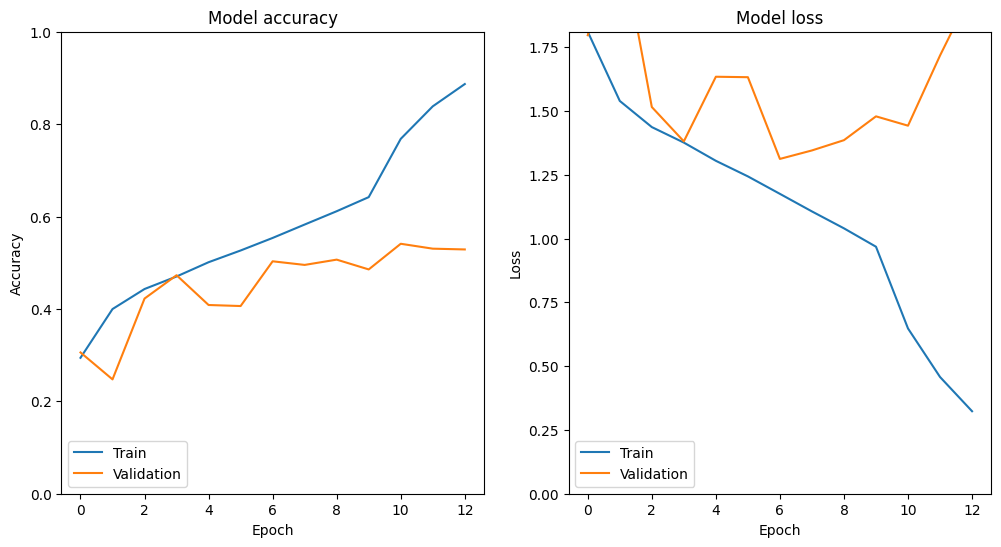

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_E = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_e.h5')

In [ ]:
validation_Y_pred = model_E.predict(validation_X)

113/113 [==============================] - 2s 9ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.38      0.43      0.40       467
           1       0.54      0.45      0.49        56
           2       0.43      0.33      0.37       496
           3       0.72      0.74      0.73       895
           4       0.40      0.39      0.40       653
           5       0.70      0.67      0.69       415
           6       0.45      0.52      0.48       607

    accuracy                           0.53      3589
   macro avg       0.52      0.50      0.51      3589
weighted avg       0.53      0.53      0.53      3589



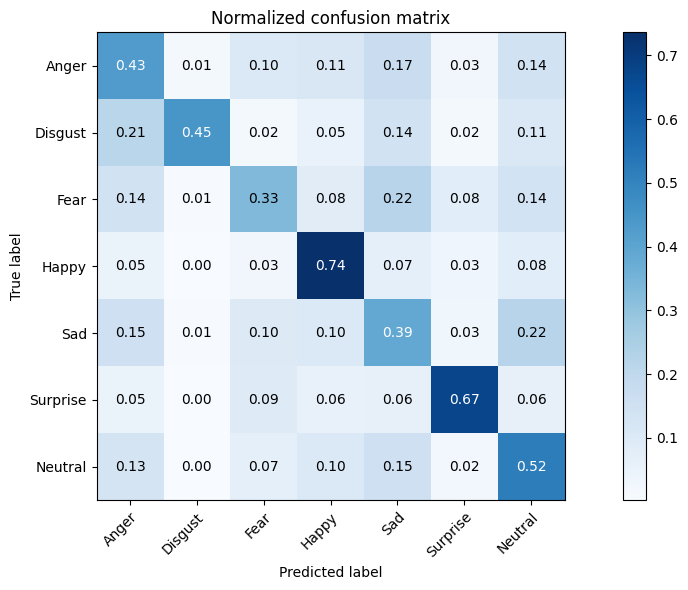

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_E.evaluate(test_X, test_Y)

113/113 [==============================] - 3s 11ms/step - loss: 1.8166 - accuracy: 0.5469


In [ ]:
test_Y_pred = model_E.predict(test_X)

113/113 [==============================] - 1s 9ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.41      0.45      0.43       491
           1       0.69      0.56      0.62        55
           2       0.45      0.35      0.39       528
           3       0.75      0.75      0.75       879
           4       0.40      0.40      0.40       594
           5       0.72      0.69      0.71       416
           6       0.47      0.54      0.50       626

    accuracy                           0.55      3589
   macro avg       0.56      0.54      0.54      3589
weighted avg       0.55      0.55      0.55      3589



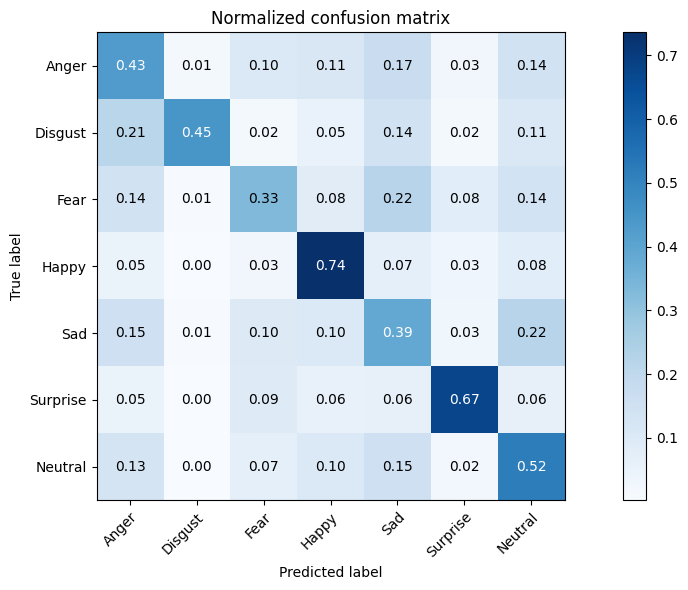

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Model F: mini Xception


### Build model F

In [ ]:
def mini_Xception(input_shape, num_classes):

    regularization = l2(0.01)
    img_input = Input(input_shape)

    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
   
    return model

In [ ]:
model_F = mini_Xception((48, 48, 1), num_class)
model_F.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 8)    72          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 46, 46, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['batch_normalization[0][0]']

In [ ]:
plot_model(model_F, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_f.png', show_shapes=True, show_layer_names=True)

### Train model F

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_f.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_F.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size=32

# Fit the model.
history = model_F.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=20,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/20
897/897 [==============================] - 24s 23ms/step - loss: 1.7571 - accuracy: 0.3802 - val_loss: 1.6656 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 2/20
897/897 [==============================] - 19s 21ms/step - loss: 1.4360 - accuracy: 0.4861 - val_loss: 1.4007 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 3/20
897/897 [==============================] - 18s 20ms/step - loss: 1.3075 - accuracy: 0.5243 - val_loss: 1.5088 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 4/20
897/897 [==============================] - 18s 20ms/step - loss: 1.2327 - accuracy: 0.5518 - val_loss: 1.3350 - val_accuracy: 0.5128 - lr: 0.0010
Epoch 5/20
897/897 [==============================] - 18s 20ms/step - loss: 1.1812 - accuracy: 0.5712 - val_loss: 1.2529 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 6/20
897/897 [==============================] - 19s 21ms/step - loss: 1.1367 - accuracy: 0.5901 - val_loss: 1.3418 - val_accuracy: 0.5170 - lr: 0.0010
Epoch 7/20
897/897 [==============================] - 19s 

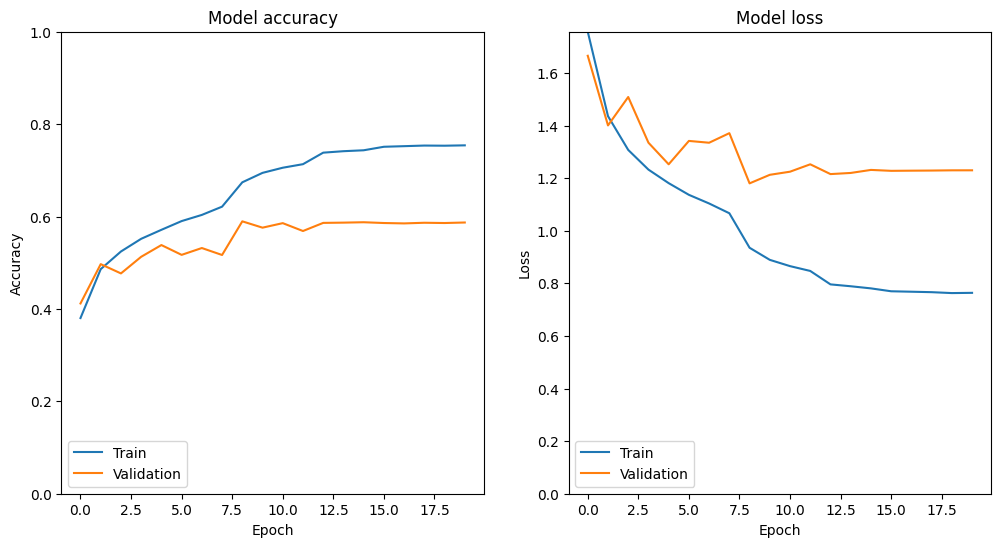

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_F = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_f.h5')

In [ ]:
validation_Y_pred = model_F.predict(validation_X)

113/113 [==============================] - 1s 3ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.48      0.49      0.49       467
           1       0.68      0.30      0.42        56
           2       0.44      0.37      0.40       496
           3       0.78      0.80      0.79       895
           4       0.47      0.48      0.47       653
           5       0.76      0.73      0.75       415
           6       0.50      0.56      0.53       607

    accuracy                           0.59      3589
   macro avg       0.59      0.53      0.55      3589
weighted avg       0.59      0.59      0.58      3589



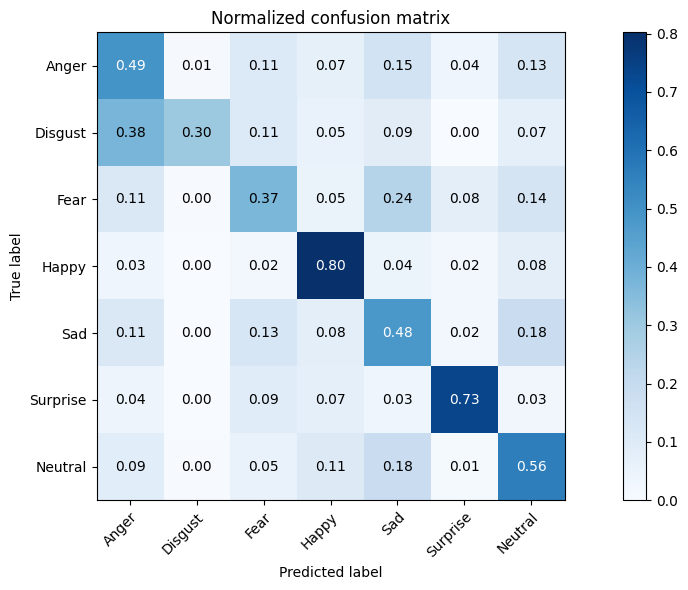

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_F.evaluate(test_X, test_Y)

113/113 [==============================] - 1s 7ms/step - loss: 1.1996 - accuracy: 0.5940


In [ ]:
test_Y_pred = model_F.predict(test_X)

113/113 [==============================] - 0s 3ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       491
           1       0.46      0.24      0.31        55
           2       0.42      0.35      0.38       528
           3       0.77      0.84      0.81       879
           4       0.42      0.47      0.45       594
           5       0.74      0.69      0.71       416
           6       0.59      0.61      0.60       626

    accuracy                           0.59      3589
   macro avg       0.56      0.53      0.54      3589
weighted avg       0.59      0.59      0.59      3589



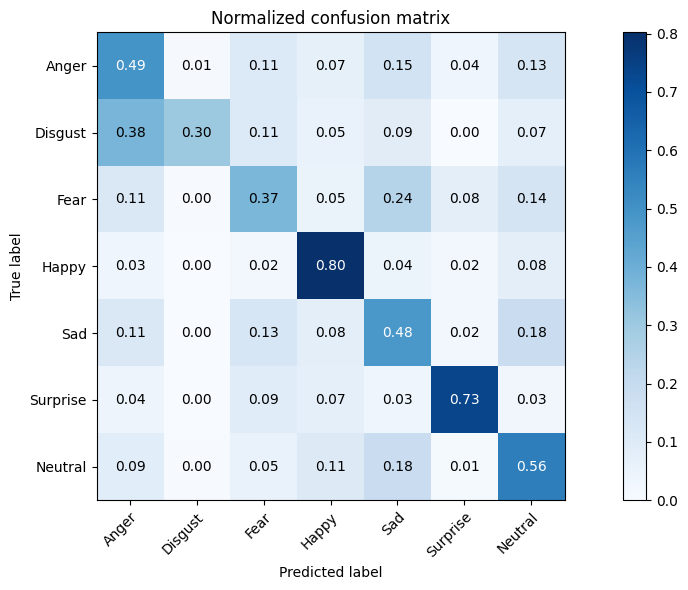

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Model G: tiny AlexNet


In [ ]:
def tiny_AlexNet(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                            strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5),
                            strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Conv2D(filters=64, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Conv2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Conv2D(filters=num_classes, kernel_size=(1, 1), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax', name='predictions'))

    return model

In [ ]:
model_G = tiny_AlexNet((48, 48, 1), num_class)
model_G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0

In [ ]:
plot_model(model_G, to_file='/content/drive/MyDrive/TFG_FER/CNN/model_g.png', show_shapes=True, show_layer_names=True)

### Train model G

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_g.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_G.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size=64

# Fit the model.
history = model_G.fit(train_X,     
                      train_Y,
                      batch_size=batch_size, 
                      epochs=30,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/30
448/448 [==============================] - 23s 49ms/step - loss: 1.7045 - accuracy: 0.3140 - val_loss: 1.7282 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - 20s 45ms/step - loss: 1.4820 - accuracy: 0.4323 - val_loss: 1.5372 - val_accuracy: 0.4032 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - 20s 45ms/step - loss: 1.3901 - accuracy: 0.4685 - val_loss: 1.3999 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - 20s 46ms/step - loss: 1.3314 - accuracy: 0.4939 - val_loss: 1.3619 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 5/30
448/448 [==============================] - 20s 45ms/step - loss: 1.2847 - accuracy: 0.5116 - val_loss: 1.3214 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 6/30
448/448 [==============================] - 20s 45ms/step - loss: 1.2526 - accuracy: 0.5228 - val_loss: 1.2406 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 7/30
448/448 [==============================] - 20s 

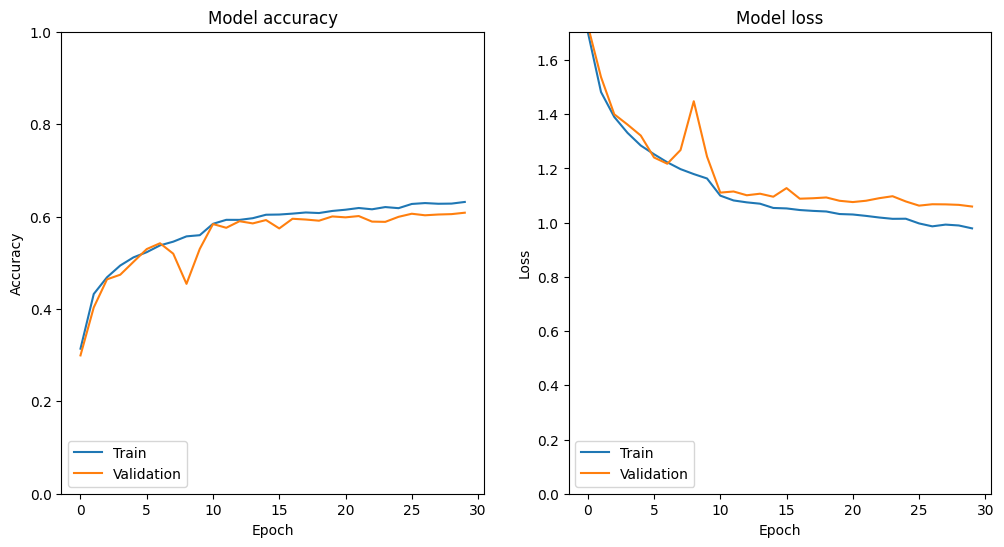

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_G = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_g.h5')

In [ ]:
validation_Y_pred = model_G.predict(validation_X)

113/113 [==============================] - 1s 7ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55       467
           1       0.67      0.29      0.40        56
           2       0.48      0.21      0.29       496
           3       0.79      0.84      0.81       895
           4       0.47      0.53      0.50       653
           5       0.71      0.78      0.74       415
           6       0.52      0.65      0.58       607

    accuracy                           0.61      3589
   macro avg       0.60      0.55      0.55      3589
weighted avg       0.60      0.61      0.59      3589



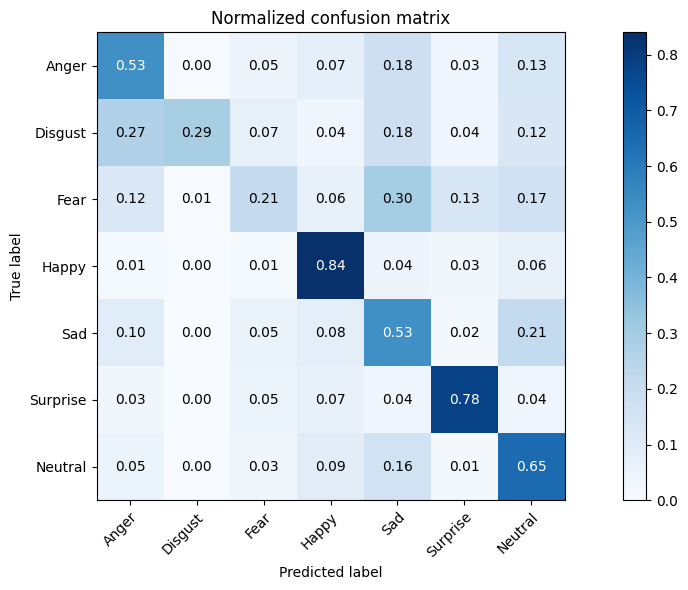

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_G.evaluate(test_X, test_Y)

113/113 [==============================] - 1s 7ms/step - loss: 1.0347 - accuracy: 0.6144


In [ ]:
test_Y_pred = model_G.predict(test_X)

113/113 [==============================] - 1s 6ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       491
           1       0.62      0.27      0.38        55
           2       0.52      0.25      0.34       528
           3       0.78      0.87      0.82       879
           4       0.44      0.55      0.49       594
           5       0.73      0.75      0.74       416
           6       0.56      0.67      0.61       626

    accuracy                           0.61      3589
   macro avg       0.60      0.55      0.56      3589
weighted avg       0.61      0.61      0.60      3589



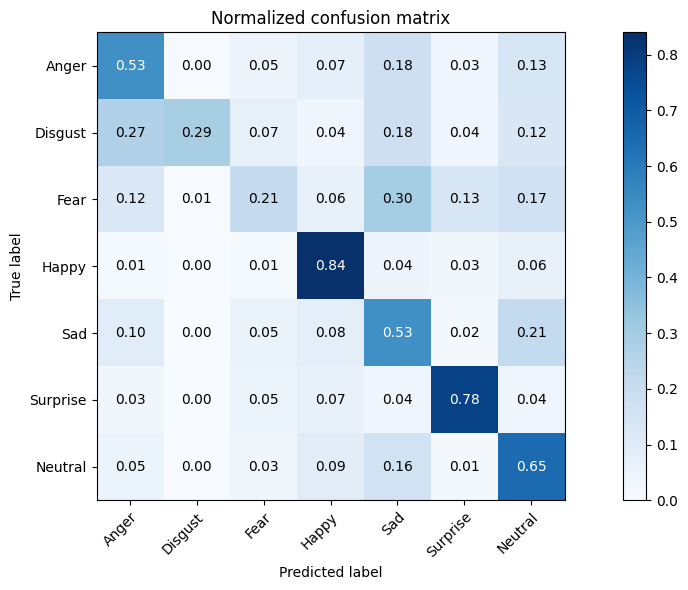

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Bibliography



*   https://github.com/pranjalrai-iitd/FER2013-Facial-Emotion-Recognition
*  https://github.com/neha01/Realtime-Emotion-Detection
*  https://github.com/LinHuiTeng/EmotionDetector 
*  https://github.com/liminze/Real-time-Facial-Expression-Recognition-and-Fast-Face-Detection 
*  https://github.com/kumarnikhil936/face_emotion_recognition_cnn
*  https://github.com/XiuweiHe/EmotionClassifier

